In [1]:
import os
import cv2
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths to training and testing data folders
train_data_folder = r'ISBI2016_ISIC_Part3_Training_Data'
test_data_folder = r'ISBI2016_ISIC_Part3_Test_Data'

# Function to load images from a folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)  # Read the image using OpenCV
            if img is not None:
                images.append(img)
    return images

# Load training images
train_images = load_images_from_folder(train_data_folder)
print(f"Number of training images: {len(train_images)}")

# Load testing images
test_images = load_images_from_folder(test_data_folder)
print(f"Number of testing images: {len(test_images)}")

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2,  # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,  # Apply shear transformation
    zoom_range=0.2,  # Randomly zoom into images
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill in newly created pixels after rotation or shift
)

# Create a directory to save augmented images (optional)
augmented_images_dir = 'augmented_images'
os.makedirs(augmented_images_dir, exist_ok=True)

# Perform data augmentation on training images
for i, img in enumerate(train_images):
    img = np.expand_dims(img, axis=0)  # Keras expects batches of images
    augmented_img_gen = datagen.flow(img, batch_size=1, save_to_dir=augmented_images_dir, save_prefix='aug', save_format='jpg')
    # Generate augmented images
    for _ in range(5):  # Generate 5 augmented images for each original image
        next(augmented_img_gen)

print("Data augmentation completed.")


Number of training images: 900
Number of testing images: 379
Data augmentation completed.


In [1]:
from tqdm import tqdm
import numpy as np
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline
import seaborn as sns
import cv2
import os
import re


from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50

In [2]:
# Path to the CSV file containing image labels
csv_file_path = 'ISBI2016_ISIC_Part3_Training_GroundTruth.csv'

# Read the CSV file into a pandas DataFrame
df_labels = pd.read_csv(csv_file_path)

# Define your class names based on unique values in the 'benign_malignant' column
class_names = sorted(df_labels['benign_malignant'].unique())

# Path to the directory containing training image files
train_path = 'ISBI2016_ISIC_Part3_Training_Data'

X_train = []
y_train = []

# Load training data
for image_name in os.listdir(train_path):
    if image_name.endswith('.jpg'):  # Assuming images are in JPG format
        image_path = os.path.join(train_path, image_name)
        
        # Load image
        image = cv2.imread(image_path)
        image = cv2.resize(image, (224, 224))
        
        # Get label for the current image from DataFrame
        label = df_labels.loc[df_labels['image_name'] == image_name[:-4], 'benign_malignant'].values[0]
        
        # Append image and corresponding label
        X_train.append(image)
        y_train.append(class_names.index(label))

X_train = np.array(X_train)
y_train = np.array(y_train)

# Path to the directory containing test image files
test_path = 'ISBI2016_ISIC_Part3_Test_Data'

X_test = []

# Load testing data
for image_name in os.listdir(test_path):
    if image_name.endswith('.jpg'):  # Assuming images are in JPG format
        image_path = os.path.join(test_path, image_name)
        
        # Load image
        image = cv2.imread(image_path)
        image = cv2.resize(image, (224, 224))
        
        # Append image
        X_test.append(image)

X_test = np.array(X_test)

# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)


In [3]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

def construct_PPNet(base_architecture='resnet50', num_classes=2):
    # Define base architecture
    if base_architecture == 'resnet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    else:
        raise ValueError("Unsupported base architecture. Supported options: 'resnet50'")

    # Add custom classifier layers on top of the base model
    classifier = tf.keras.models.Sequential([
        base_model,
        # GlobalAveragePooling2D(),
        Dense(num_classes, activation='softmax')
    ])

    # Compile the classifier
    optimizer = Adam(learning_rate=0.001)
    loss = 'sparse_categorical_crossentropy'
    metrics = ['accuracy']

    # Add class weights to the compiled model
    classifier.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=metrics,
                        loss_weights=class_weights_dict)

    return classifier

In [4]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Assuming you have X_train, y_train, X_val, y_val defined

# Calculate class weights using compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# Create a dictionary mapping class labels to class weights
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

# Instantiate the PPNet model
classifier_model = construct_PPNet(base_architecture='resnet50', num_classes=len(np.unique(y_train)))

# Display model summary
classifier_model.summary()

# Train the model with class weights
history = classifier_model.fit(X_train, y_train, 
                               epochs=20, 
                               validation_data=(X_val, y_val), 
                               class_weight=class_weights_dict)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/20
23/23 [==============================] - 198s 8s/step - loss: 1.0015 - accuracy: 0.5833 - val_loss: 978849.6250 - val_accuracy: 0.8056
Epoch 2/20
23/23 [==============================] - 185s 8s/step - loss: 1.1680 - accuracy:

In [5]:
model_path = 'F:/Desktop/Internship/model1.h5'
classifier_model.save(model_path)

In [6]:
# Evaluate the model on test data (no labels available for test data)
test_predictions = classifier_model.predict(X_test)

# Assuming you have ground truth labels for test data in a separate CSV file
# For demonstration purposes, I'll assume a simple output of the predictions
print("Test Predictions:")
for idx, prediction in enumerate(test_predictions):
    print(f"Image {idx}: {class_names[np.argmax(prediction)]}")

12/12 [==============================] - 21s 2s/step
Test Predictions:
Image 0: benign
Image 1: benign
Image 2: benign
Image 3: benign
Image 4: benign
Image 5: benign
Image 6: benign
Image 7: benign
Image 8: benign
Image 9: malignant
Image 10: benign
Image 11: benign
Image 12: benign
Image 13: benign
Image 14: benign
Image 15: benign
Image 16: benign
Image 17: benign
Image 18: benign
Image 19: benign
Image 20: malignant
Image 21: malignant
Image 22: benign
Image 23: benign
Image 24: benign
Image 25: benign
Image 26: benign
Image 27: benign
Image 28: benign
Image 29: benign
Image 30: benign
Image 31: benign
Image 32: benign
Image 33: benign
Image 34: benign
Image 35: benign
Image 36: benign
Image 37: benign
Image 38: benign
Image 39: benign
Image 40: malignant
Image 41: benign
Image 42: benign
Image 43: benign
Image 44: benign
Image 45: malignant
Image 46: benign
Image 47: benign
Image 48: benign
Image 49: malignant
Image 50: benign
Image 51: benign
Image 52: benign
Image 53: benign
Ima

In [8]:
# Get predictions on the test data
y_pred_prob = classifier_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels


12/12 [==============================] - 18s 2s/step


In [10]:
# Evaluate the model on the validation data
val_loss, val_accuracy = classifier_model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


6/6 [==============================] - 9s 1s/step - loss: 0.6929 - accuracy: 0.8111
Validation Loss: 0.6929453611373901
Validation Accuracy: 0.8111110925674438


In [11]:
from sklearn.metrics import roc_auc_score

# Get predicted probabilities on the validation data
y_val_prob = classifier_model.predict(X_val)

# Calculate AUC score
auc_score = roc_auc_score(y_val, y_val_prob[:, 1])  # Assuming binary classification

print(f"AUC Score: {auc_score}")


6/6 [==============================] - 9s 1s/step
AUC Score: 0.6007881773399015


6/6 [==============================] - 9s 1s/step


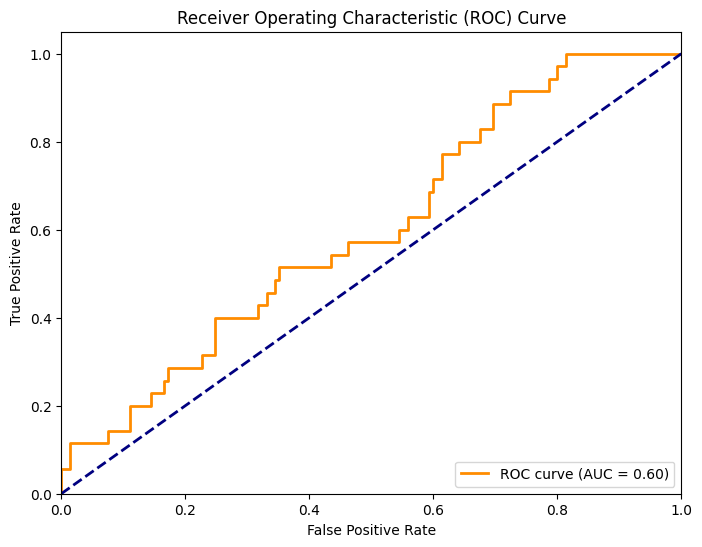

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities on the validation data
y_val_prob = classifier_model.predict(X_val)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_val, y_val_prob[:, 1])  # Assuming binary classification
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


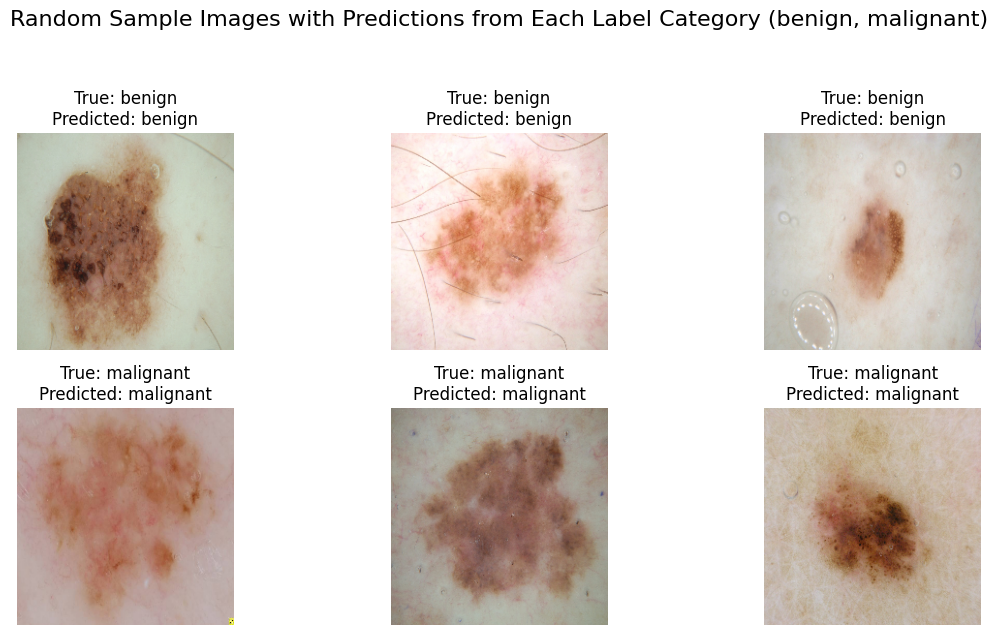

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Assuming you have access to your dataset and labels
# Modify this according to your dataset structure and label categories
# Example: class_names = ['benign', 'malignant']

class_names = ['benign', 'malignant']
num_samples_per_class = 3  # Number of sample images to plot per class

# Initialize a dictionary to store sample images and labels for each label category
sample_data = {class_name: {'images': [], 'labels': []} for class_name in class_names}

# Collect sample images and labels for each label category
for image, label in zip(X_train, y_train):
    class_name = class_names[label]
    sample_data[class_name]['images'].append(image)
    sample_data[class_name]['labels'].append(label)

# Plot random sample images from each label category
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(class_names):
    # Randomly select sample images from the current label category
    random_indices = np.random.choice(len(sample_data[class_name]['images']), num_samples_per_class, replace=False)
    
    for j, idx in enumerate(random_indices):
        plt.subplot(len(class_names), num_samples_per_class, i * num_samples_per_class + j + 1)
        plt.imshow(cv2.cvtColor(sample_data[class_name]['images'][idx], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
        plt.title(f"True: {class_names[sample_data[class_name]['labels'][idx]]}\nPredicted: {class_name}")
        plt.axis('off')

plt.suptitle(f"Random Sample Images with Predictions from Each Label Category ({', '.join(class_names)})", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()
